C:\Users\jerry\AppData\Local\Temp\ipykernel_26412\2014818423.py:177: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


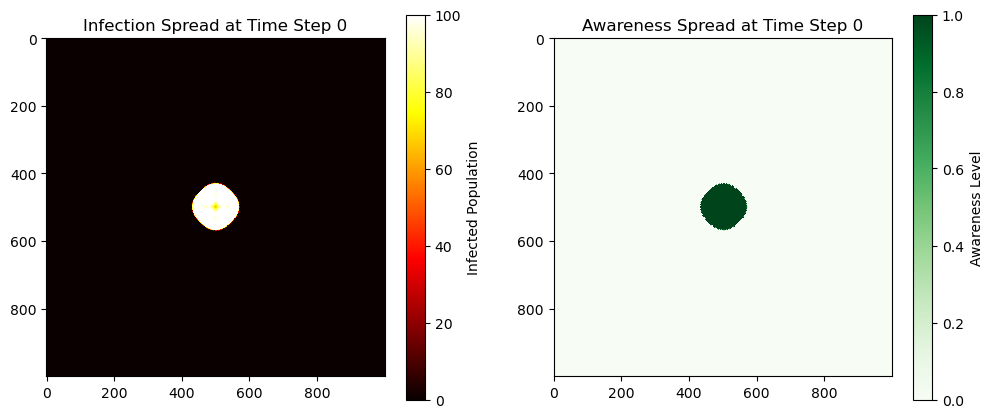

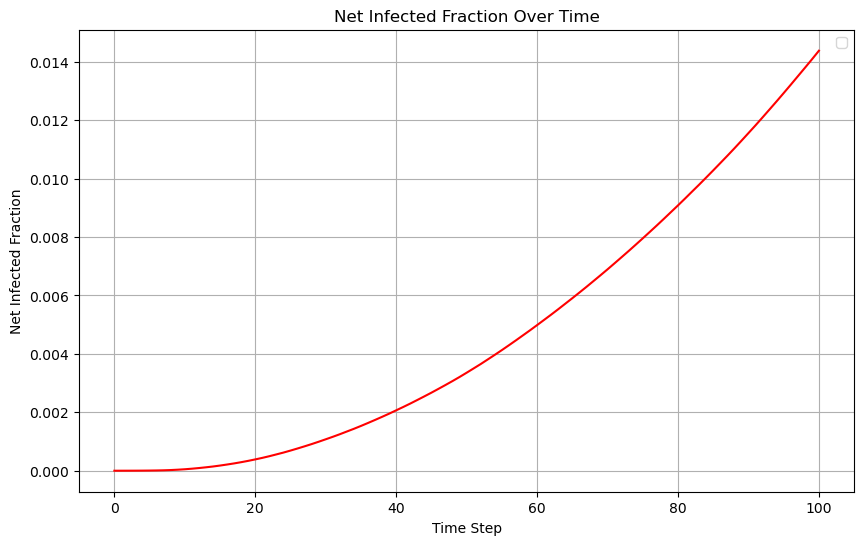

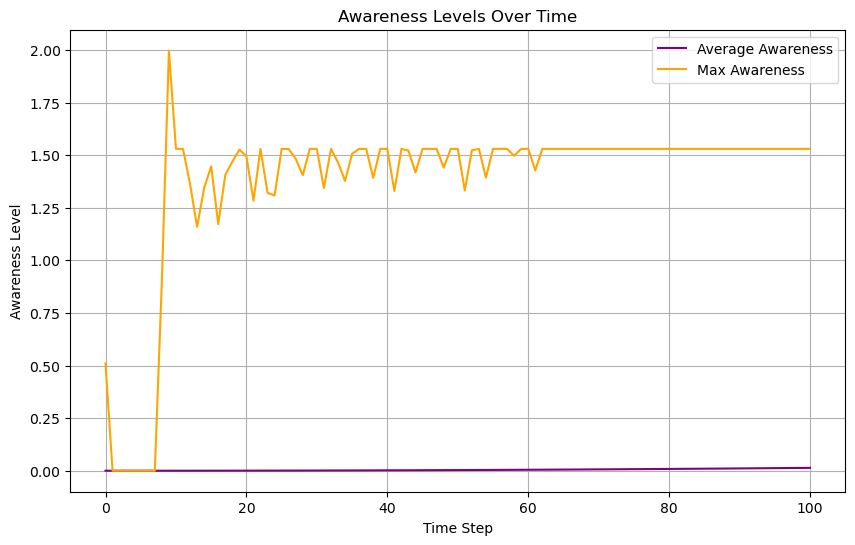

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from numba import jit

# Model Constants
GRID_SIZE = 1000  # Size of the grid representing the population
BETA = 0.8  # Infection rate
GAMMA = 0.05  # Recovery rate
DELTA = 0.8  # Rate of immunity waning (Recovered to Susceptible)
D_INFECTION = 0.25  # Infection diffusivity for Fick's Second Law
D_AWARENESS = 0.5  # Awareness diffusivity for Fick's Second Law
KAPPA = 0.05  # Awareness increase rate due to infections
LAMBDA = 0.1  # Awareness decay rate due to existing awareness
MIN_AWARENESS_DIFFUSION = 0.01  # Minimum awareness diffusion rate
LOCKDOWN_DIFFUSIVITY = 0.0001  # Reduced infection diffusivity during lockdown
S_MEAN = 85  # Mean number of susceptible individuals per cell
S_STD = 50  # Standard deviation for susceptible individuals per cell
LEAKAGE_RATE = 2  # Increased awareness decay over time
I_A_link = 2  # Coupling factor between infection and awareness

# Initial Conditions
INITIAL_INFECTED = 100  # Initial number of infected individuals
INITIAL_AWARENESS = 1  # Initial awareness level
TIME_STEPS = 1500  # Total number of simulation time steps
LOCKDOWN_THRESHOLD_PERCENT = 40  # Trigger lockdown when 40% of total population is infected

# Initialize grid
S = np.clip(np.random.normal(S_MEAN, S_STD, (GRID_SIZE, GRID_SIZE)), 0, 100).astype(int)  # Susceptible individuals
I = np.zeros((GRID_SIZE, GRID_SIZE))  # Infected individuals
R = np.zeros((GRID_SIZE, GRID_SIZE))  # Recovered individuals
A = np.zeros((GRID_SIZE, GRID_SIZE))  # Awareness level

# Ensure total population in each cell is 100
for x in range(GRID_SIZE):
    for y in range(GRID_SIZE):
        S[x, y] = min(S[x, y], 100)
        R[x, y] = 100 - S[x, y]

# Set initial infection and awareness in the center cell
center = (GRID_SIZE // 2, GRID_SIZE // 2)
I[center] = INITIAL_INFECTED
S[center] -= INITIAL_INFECTED
A[center] = INITIAL_AWARENESS

# Lists to store data over time
net_infected_fraction_data = []  # Fraction of infected population over time
average_awareness_data = []  # Average awareness level over time
max_awareness_data = []  # Maximum awareness level over time
lockdown_triggered = False  # Flag to indicate if lockdown has been triggered
lockdown_step = None  # Time step when lockdown is triggered
lockdown_infection_percent = None  # Infection percent at lockdown

# Lockdown function to reduce infection diffusivity and store lockdown details
def lockdown(threshold_percent, current_infected, t):
    global D_INFECTION, lockdown_triggered, lockdown_step, lockdown_infection_percent
    if not lockdown_triggered and current_infected >= threshold_percent:
        D_INFECTION = LOCKDOWN_DIFFUSIVITY
        lockdown_triggered = True
        lockdown_step = t
        lockdown_infection_percent = current_infected

# Helper function to apply Fick's Second Law for diffusion between cells
@jit(nopython=True)
def apply_diffusion(grid, D, A):
    """
    Apply Fick's Second Law for diffusion between cells.
    Args:
        grid: The grid representing the quantity to diffuse (e.g., infection or awareness).
        D: Diffusivity constant.
        A: Awareness grid, affecting the diffusion rate.
    Returns:
        The updated grid after applying diffusion.
    """
    new_grid = np.copy(grid)
    for x in range(1, GRID_SIZE - 1):
        for y in range(1, GRID_SIZE - 1):
            diffusion_rate = D * np.exp(-I_A_link * A[x, y]) + MIN_AWARENESS_DIFFUSION
            new_grid[x, y] += diffusion_rate * (grid[x+1, y] + grid[x-1, y] + grid[x, y+1] + grid[x, y-1] - 4 * grid[x, y])
    return new_grid

# Set up the figure for the animation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Text placeholder for lockdown status
lockdown_text = fig.text(0.5, 0.95, '', ha='center', va='center', fontsize=16, color='red', weight='bold')

# Set up the infection heatmap with color scaling between 0 and 100
cax1 = ax1.imshow(I, cmap='hot', interpolation='nearest', vmin=0, vmax=100)
plt.colorbar(cax1, ax=ax1, label='Infected Population')
ax1.set_title('Infection Spread at Time Step 0')

# Set up the awareness heatmap with color scaling from min to max awareness
cax2 = ax2.imshow(A, cmap='Greens', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar(cax2, ax=ax2, label='Awareness Level')
ax2.set_title('Awareness Spread at Time Step 0')

@jit(nopython=True)
def update_grids(S, I, R, A):
    """
    Update the grids for Susceptible, Infected, Recovered, and Awareness levels.
    Args:
        S: Susceptible grid.
        I: Infected grid.
        R: Recovered grid.
        A: Awareness grid.
    Returns:
        Updated S, I, R, A grids.
    """
    new_S = np.copy(S)
    new_I = np.copy(I)
    new_R = np.copy(R)
    new_A = np.copy(A)
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            new_infections = BETA * S[x, y] * I[x, y] / (S[x, y] + I[x, y] + R[x, y])  # New infections
            new_recoveries = GAMMA * I[x, y]  # Recoveries
            new_waning = DELTA * R[x, y]  # Waning immunity (R -> S)
            awareness_increase = KAPPA * I[x, y]  # Awareness increase due to infections
            awareness_decrease = LAMBDA * A[x, y] + LEAKAGE_RATE  # Awareness decrease over time
            new_A[x, y] = max(0, min(1, A[x, y] + awareness_increase - awareness_decrease))  # Update awareness
            new_S[x, y] = max(S[x, y] - new_infections + new_waning, 0)  # Update susceptible individuals
            new_I[x, y] = max(I[x, y] + new_infections - new_recoveries, 0)  # Update infected individuals
            new_R[x, y] = max(R[x, y] + new_recoveries - new_waning, 0)  # Update recovered individuals
    return new_S, new_I, new_R, new_A

def update(t):
    """
    Update the entire model for a single time step.
    Args:
        t: Current time step.
    """
    global S, I, R, A, net_infected_fraction_data, average_awareness_data, max_awareness_data
    # Apply SIR dynamics in each cell, incorporating waning immunity (SIRS model)
    S, I, R, A = update_grids(S, I, R, A)

    # Update infection and awareness diffusion
    I = apply_diffusion(I, D_INFECTION, A)
    A = apply_diffusion(A, D_AWARENESS, np.zeros_like(A))

    # Update the infection plot
    cax1.set_array(I)
    ax1.set_title(f'Infection Spread at Time Step {t}')

    # Update the awareness plot
    cax2.set_array(A)
    ax2.set_title(f'Awareness Spread at Time Step {t}')

    # Track net infected fraction
    net_infected_fraction = np.sum(I) / (GRID_SIZE * GRID_SIZE * 100)
    net_infected_fraction_data.append(net_infected_fraction)

    # Track awareness metrics
    average_awareness_data.append(np.mean(A))
    max_awareness_data.append(np.max(A))

    # Trigger lockdown if necessary and update lockdown text
    lockdown(LOCKDOWN_THRESHOLD_PERCENT, net_infected_fraction * 100, t)
    if lockdown_triggered:
        lockdown_text.set_text(f"Lockdown Triggered (Timestep {lockdown_step}, {lockdown_infection_percent:.2f}% Infection)")
    else:
        lockdown_text.set_text("")

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=TIME_STEPS, repeat=False)

# Save the animation as a video file
ani.save(f'pandemic_spread_with_awareness-{LOCKDOWN_THRESHOLD_PERCENT}.mp4', writer='ffmpeg', fps=30)

# Plot net infected fraction over time
plt.figure(figsize=(10, 6))
plt.plot(net_infected_fraction_data, color='red')
plt.xlabel('Time Step')
plt.ylabel('Net Infected Fraction')
plt.title('Net Infected Fraction Over Time')
if lockdown_triggered:
    plt.axvline(x=lockdown_step, color='blue', linestyle='--', label=f'Lockdown Triggered (Timestep {lockdown_step})')
plt.legend()
plt.grid(True)
plt.savefig(f'net_infected_fraction_over_time-{LOCKDOWN_THRESHOLD_PERCENT}.png')

# Plot average and max awareness over time
plt.figure(figsize=(10, 6))
plt.plot(average_awareness_data, label='Average Awareness', color='purple')
plt.plot(max_awareness_data, label='Max Awareness', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Awareness Level')
plt.title('Awareness Levels Over Time')
plt.legend()
plt.grid(True)
plt.savefig(f'awareness_levels_over_time-{LOCKDOWN_THRESHOLD_PERCENT}.png')
